In [1]:
import numpy as np
from numba import njit, prange
from scipy.linalg import svd, qr, inv, pinv
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.linalg import lstsq

import theano
import pickle



import theano.tensor as T
from theano.ifelse import ifelse
from theano.tensor.nlinalg import svd
from theano import function, shared
import arviz as az

from pymc_classes import LogLike



WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [10]:
np.__config__.show()

blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
    library_dirs = ['C:\\projects\\numpy-wheels\\numpy\\build\\openblas_info']
    libraries = ['openblas_info']
    language = f77
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    library_dirs = ['C:\\projects\\numpy-wheels\\numpy\\build\\openblas_info']
    libraries = ['openblas_info']
    language = f77
    define_macros = [('HAVE_CBLAS', None)]
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    library_dirs = ['C:\\projects\\numpy-wheels\\numpy\\build\\openblas_lapack_info']
    libraries = ['openblas_lapack_info']
    language = f77
    define_macros = [('HAVE_CBLAS', None)]
lapack_opt_info:
    library_dirs = ['C:\\projects\\numpy-wheels\\numpy\\build\\openblas_lapack_info']
    libraries = ['openblas_lapack_info']
    language = f77
    define_macros = [('HAVE_CBLAS', None)]


In [2]:
import pymc3 as pm
from pymc3.ode import DifferentialEquation


path = r"C:\Users\dominik\Documents\Projects\Bilirubin\UV-Vis data"
# path = r"C:\Users\Dominik\Documents\MUNI\Organic Photochemistry\Projects\2019-Bilirubin project\UV-VIS\QY measurement\Photodiode\new setup"


data_led = np.loadtxt(path + r'\LED sources.txt', delimiter='\t', skiprows=1)

LED_355 = data_led[:, 1] / np.trapz(data_led[:, 1])
LED_375 = data_led[:, 2] / np.trapz(data_led[:, 2])
LED_405 = data_led[:, 3] / np.trapz(data_led[:, 3])
LED_420 = data_led[:, 4] / np.trapz(data_led[:, 4])
LED_450 = data_led[:, 5] / np.trapz(data_led[:, 5])
LED_470 = data_led[:, 6] / np.trapz(data_led[:, 6])
LED_490 = data_led[:, 7] / np.trapz(data_led[:, 7])

In [3]:
# pythonic version
def _lstsq_D(C, D):
    U, S, VT = np.linalg.svd(C, full_matrices=False)

    Sr = S[S > S[0] * 1e-10]
    Ur = U[:, :Sr.shape[0]]

    CC_plus_D = Ur.dot(Ur.T).dot(D)

    return CC_plus_D

def Phi(phis, lambda_C=400, wavelengths=None):
    assert isinstance(phis, (list, np.ndarray))
    return sum(par * ((lambda_C - wavelengths) / 100) ** i for i, par in enumerate(phis))

# C, D = T.dmatrix('C'), T.dmatrix('D')

# # theano version
# U, S, VT = svd(C, full_matrices=0, compute_uv=1)

# Sr = S[S > S[0] * 1e-8]
# Ur = U[:, :Sr.shape[0]]
# CC_plus_D = Ur.dot(Ur.T).dot(D)

# _lstsq_D = function([C, D], CC_plus_D)



Text(0, 0.5, 'Absorbance')

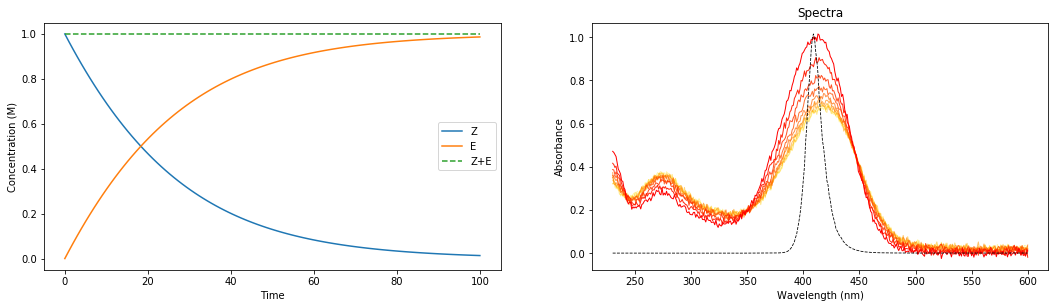

In [8]:
eps = np.loadtxt(r'C:\Users\dominik\Documents\GitHub Repositories\Jupyter-Tutorials\Photoreaction kinetics\fit-A.csv',
                 delimiter=',', skiprows=1)

# eps = np.loadtxt(r'C:\Users\Dominik\Documents\MUNI\Organic Photochemistry\Projects\2019-Bilirubin project\UV-VIS\QY measurement\Photodiode\new setup\spectra_fit.csv',
#                  delimiter=',', skiprows=1)
ST = eps[:, [1, 2]].T  # ST is a matrix of n x w
ST /= ST.max()

wavelengths = eps[:, 0] + 230
N = 100
times = np.linspace(0, 100, N)
# k = 0.05

# C = np.exp(-k * times[:, None])
# D = C @ ST[None, :]

# D = np.random.normal(D, 0.05)


phi = Phi([0.2], 400, wavelengths)
q0, V, c0 = 2e-1, 1, 1
I_source = LED_405

_0 = np.zeros(wavelengths.shape) if isinstance(phi, np.ndarray) else 0

K = np.asarray([[-phi,  _0],
                [+phi,  _0]])

K = np.transpose(K, (2, 0, 1))

const = np.log(10)
eps = ST


def dc_dt_py(c, t):
#     q0 = p[0] 
    c_eps = c[:, None] * eps  # hadamard product
    c_dot_eps = c_eps.sum(axis=0)
    
    q = c_eps * np.where(c_dot_eps <= 0.001, const - c_dot_eps * const * const / 2,
                                     (1 - np.exp(-c_dot_eps * const)) / c_dot_eps) * I_source
    
    product = np.matmul(K, q.T[..., None]).squeeze()  # w x n x 1
    
    return q0 / V * (product.sum(0) - (product[0] + product[-1]) / 2)
    
#     return q0 / V * np.trapz(product, axis=0).squeeze()

@njit(fastmath=True, parallel=False)
def dc_dt_numba(c, t):
    c_eps = c.reshape((-1, 1)) * eps  # hadamard product
    c_dot_eps = c_eps.sum(0)
    
    fk_factor = np.zeros_like(c_dot_eps)
    for i in prange(c_dot_eps.shape[0]):
        if c_dot_eps[i] < 0.001:
            fk_factor[i] = const - c_dot_eps[i] * const * const / 2
        else:
            fk_factor[i] = (1 - np.exp(-c_dot_eps[i] * const)) / c_dot_eps[i]
            
    q = c_eps * fk_factor * I_source
    
    product = np.zeros((c_dot_eps.shape[0], c.shape[0]))
    for i in prange(c_dot_eps.shape[0]):
        product[i] = K[i].dot(q[:, i])
        
    return q0 / V * (product.sum(0) - (product[0] + product[-1]) / 2)
    

def dc_dt(c, t, p):
    q0 = p[0] 

    c_eps = c[:, None] * eps  # hadamard product
    
    c_dot_eps = c_eps.sum(axis=0)
    
#     x_abs = c_eps * T.switch(T.lt(c_dot_eps, 0.001), const - c_dot_eps * const * const / 2, 
#                    (1 - T.exp(-c_dot_eps * const)) / c_dot_eps) * I_source
    
    x_abs = c_eps * T.switch(c_dot_eps <= 0.001, const - c_dot_eps * const * const / 2, 
                   (1 - T.exp(-c_dot_eps * const)) / c_dot_eps) * I_source
    
#     n = x_abs.T[:, :, None]
    
    _product, _ = theano.scan(lambda a, b: T.dot(a, b), sequences=[K, x_abs.T[..., None]])
    
#     product = T.batched_dot(K, x_abs.T[..., None])

    return q0 / V * (_product.sum(axis=0) - (_product[0, ...] + _product[-1, ...]) / 2).squeeze()

#     x_abs = c_eps * np.where(c_dot_eps <= 0.001, const - c_dot_eps * const * const / 2, (1 - np.exp(-c_dot_eps * const)) / c_dot_eps) * I_source

#     # w x n x n   x   w x n x 1
#     product = np.matmul(K, x_abs.T[..., None])  # w x n x 1

#     return q0 / V * np.trapz(_product, axis=0).squeeze()


# t_y = T.vector("y", dtype='float64')
# t_t = T.scalar("t", dtype='float64')
# t_p = T.vector("p", dtype='float64')
# # K = T.tensor3("_K", dtype='float64')


# _func_theano = dc_dt(t_y, t_t, t_p)
# func = function([t_y, t_t, t_p], _func_theano, on_unused_input='warn')

# theano.config.blas.ldflags='-lmkl_rt'


# c = T.tensor3('a', dtype='float64')
# f = T.tensor3('b', dtype='float64')

# _product, _ = theano.scan(lambda a, b: T.dot(a, b), sequences=[c, f])

# _dot_func = function([c, f], _product)

# b = func([1, 0], 0, [1], K)
# b
# np.dot(K[0], b[50]).shape

# _dot_func(K, b).squeeze()

# np.matmul(K, func([1, 0], 0, [1])).squeeze().shape
# K
# K.shape, func([1, 0], 0, [1]).shape

# C = odeint(func, [c0, 0], times, args=((q0,), K))
# C_py = odeint(dc_dt_py, [c0, 0], times, args=((q0,), K))

# np.allclose(C, C_py, rtol=1e-8)

# dc_dt_numba(np.asarray([1, 0]), 0)

C = odeint(dc_dt_py, [c0, 0], times)   #, args=((q0
# %timeit C_numba = odeint(dc_dt_numba, [c0, 0], times)   #, args=((q0,),))

# np.allclose(C, C_numba, rtol=1e-8)


names = ['Z', 'E', 'HL', 'Unknown']

plt.rcParams['figure.figsize'] = [18, 10]
plt.subplot(2, 2, 1)
for i in range(K.shape[2]):
    plt.plot(times, C[:, i], label=names[i])
plt.plot(times, C.sum(axis=1), label='+'.join(names[0:2]), linestyle='--')
plt.xlabel('Time')
plt.ylabel('Concentration (M)')
plt.legend()

D = C @ ST  # compute data matrix
D_obs = np.random.normal(D, 0.01)


# plot time-dependent spectra
t = times.shape[0]
plt.subplot(2, 2, 2)
for i in reversed(range(0, t, 10)):
    plt.plot(wavelengths, D_obs[i], color=(1, i/t, 0, (t-i/1.4)/t), label='$t = {}$'.format(times[i]), lw=1)
plt.plot(wavelengths, D_obs.max() * I_source / I_source.max(), label='irrsource', linestyle='--', color='black', lw=0.8)
plt.title("Spectra")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')



In [5]:
# # define a theano Op for our likelihood function
# class LogLike(T.Op):

#     """
#     Specify what type of object will be passed and returned to the Op when it is
#     called. In our case we will be passing it a vector of values (the parameters
#     that define our model) and returning a single "scalar" value (the
#     log-likelihood)
#     """
#     itypes = [T.dvector] # expects a vector of parameter values when called
#     otypes = [T.dscalar] # outputs a single scalar value (the log likelihood)
    
#     # imputs phi, sigma

#     def __init__(self, D, times, wavelengths, eps_est, I_source, q_tot, V, c0):
#         """
#         Initialise the Op with various things that our log-likelihood function
#         requires. Below are the things that are needed in this particular
#         example.

#         Parameters
#         ----------
#         loglike:
#             The log-likelihood (or whatever) function we've defined
#         data:
#             The "observed" data that our log-likelihood function takes in
#         x:
#             The dependent variable (aka 'x') that our model requires
#         sigma:
#             The noise standard deviation that our function requires.
#         """

#         # add inputs as class attributes
#         self.D = D.copy()
#         self.times = times.copy()
#         self.wavelengths = wavelengths.copy()
#         self.I_source = I_source.copy()
#         self.q_tot = q_tot
#         self.V = V
#         self.c0 = c0  # initial conditions
#         self.eps_est = eps_est  # estimate of spectra == ST
        
#         self._0 = np.zeros_like(self.wavelengths)
# #         self.calls = []

        
#     def Phi(self, phis, lambda_C=400):
# #         assert isinstance(phis, (list, np.ndarray))
#         return sum(par * ((lambda_C - self.wavelengths) / 100) ** i for i, par in enumerate(phis))
   
    
#     def simulate(self, times, K, eps, q_tot, c0, V, I_source):
        
#         def dc_dt(c, t):
#             c_eps = c[:, None] * eps  # hadamard product
#             c_dot_eps = c_eps.sum(axis=0)

#             q = c_eps * np.where(c_dot_eps <= 0.001, const - c_dot_eps * const * const / 2,
#                                              (1 - np.exp(-c_dot_eps * const)) / c_dot_eps) * I_source

#             product = np.matmul(K, q.T[..., None]).squeeze()  # w x n x 1

#             return q_tot / V * (product.sum(0) - (product[0] + product[-1]) / 2)
        
#         return odeint(dc_dt, c0, times)
    
        
#     def log_likelihood(self, params, n_MCR_iter=10):
        
#         # optimize spectra for curent C params by MCR-ALS style
        
#         phi = self.Phi([params[0]], lambda_C=400)
#         sigma = params[1]
        
#         K = np.asarray([[-phi,  self._0],
#                         [+phi,  self._0]])
        
#         K = np.transpose(K, (2, 0, 1))
#         C = np.zeros((self.times.shape[0], K.shape[0]))
        
#         for i in range(n_MCR_iter):
#             # calc C
#             C = self.simulate(self.times, K, self.eps_est, self.q_tot, self.c0, self.V, self.I_source)
            
#             # calc ST by lstsq
#             self.eps_est = lstsq(C, self.D)[0]
            
#             # apply non-negative contraints on spectra
#             self.eps_est *= (self.eps_est > 0)
            
# #         self.calls.append([params[0], self.eps_est])
#         D_sim = C.dot(self.eps_est)
#         residuals = self.D - D_sim
        
#         # calculate the log of gaussian likelihood
#         N = 1 #D.size
# #         LL = -0.5*N*np.log(2*np.pi*sigma**2) - (0.5/sigma**2) * (residuals**2).sum()
#         LL =  - (0.5/sigma**2) * (residuals**2).sum()

        
#         return LL
        

#     def perform(self, node, inputs, outputs):
#         # the method that is used when calling the Op
#         params, = inputs  # this will contain my variables
 
#         # call the log-likelihood function
#         logl = self.log_likelihood(params)

#         outputs[0][0] = np.array(logl) # output the log-likelihood

In [6]:
ll = LogLike(D, times, wavelengths, ST, I_source, q0, V, [c0, 0])

byt = pickle.dumps(ll)

def _model_func(p):
    return p * p

a = _model_func

pickle.dumps(a)

# params = np.asarray([0.20, 0.01])

# # ll.Phi()
# ll.log_likelihood(params)
# 
# ll(1)

# ll.q_tot
# ll.calls[0][0]
# byt

b'\x80\x03c__main__\n_model_func\nq\x00.'

In [7]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.plot(wavelengths, ll.calls[0][1].T)
plt.plot(wavelengths, ST.T, color='black', ls='--')
plt.show()

AttributeError: 'LogLike' object has no attribute 'calls'

In [7]:
# create our Op


if __name__ == '__main__':
    
    logl = LogLike(D, times, wavelengths, ST, I_source, q0, V, [c0, 0])

    def _model_func(p):
        return logl(p)

    with pm.Model() as model:

        # Define priors
        phi = pm.Uniform('phi', lower=0, upper=1, testval=0.2)
        sigma = 0.01 #pm.Normal("sigma", sd=1, testval=0.01)

        params = T.as_tensor_variable([phi, sigma])

        pm.DensityDist('likelihood', _model_func, observed={'p': params})

        trace = pm.sample(200, tune=5, discard_tuned_samples=True, cores=6)
    
#     C = T.exp(-_k * times[:, None])
    
#     U, S, VT = svd(C, full_matrices=0, compute_uv=1)

#     Sr = S[S > S[0] * 1e-8]
#     Ur = U[:, :Sr.shape[0]]
#     CC_plus_D = Ur.dot(Ur.T).dot(D)

    # Define likelihood
#     likelihood = pm.Normal('y', mu=CC_plus_D , sd=sigma, observed=D)

#     # Inference!
#     prior = pm.sample_prior_predictive()
#     trace = pm.sample(5000, tune=1000, cores=6) # draw 3000 posterior samples using NUTS sampling
#     posterior_predictive = pm.sample_posterior_predictive(trace)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (6 chains in 6 jobs)
Slice: [phi]


RuntimeError: The communication pipe between the main process and its spawned children is broken.
In Windows OS, this usually means that the child process raised an exception while it was being spawned, before it was setup to communicate to the main process.
The exceptions raised by the child process while spawning cannot be caught or handled from the main process, and when running from an IPython or jupyter notebook interactive kernel, the child's exception and traceback appears to be lost.
A known way to see the child's error, and try to fix or handle it, is to run the problematic code as a batch script from a system's Command Prompt. The child's exception will be printed to the Command Promt's stderr, and it should be visible above this error and traceback.
Note that if running a jupyter notebook that was invoked from a Command Prompt, the child's exception should have been printed to the Command Prompt on which the notebook is running.

In [11]:
logl.calls.__len__()
# plt.rcParams['figure.figsize'] = [8, 5]
# plt.plot(wavelengths, logl.ST_opts[1400].T)
# plt.plot(wavelengths, ST.T, color='black', ls='--')
# plt.show()
all_phis = np.asarray([logl.calls[i][0] for i in range(len(logl.calls))])

# all_phis
_ = plt.hist(all_phis, bins=100, range=(0.18, 0.22))
            
            

AttributeError: 'LogLike' object has no attribute 'calls'

c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


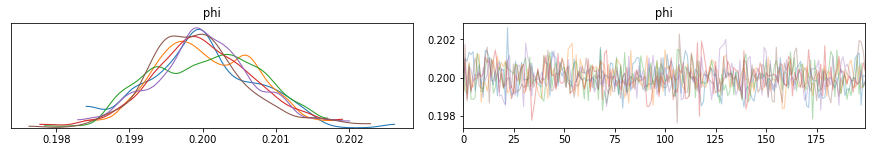

In [12]:
_ = pm.traceplot(trace)

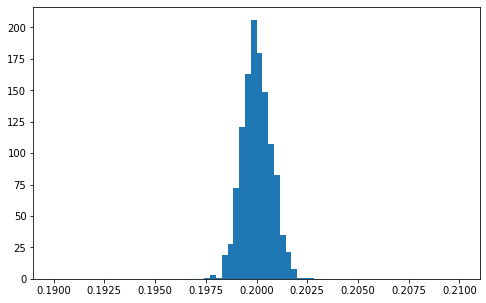

In [14]:
_ = plt.hist(trace['phi'], bins=70, range=(0.19, 0.21))

In [139]:
data = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002350B16DA48>,
      dtype=object)

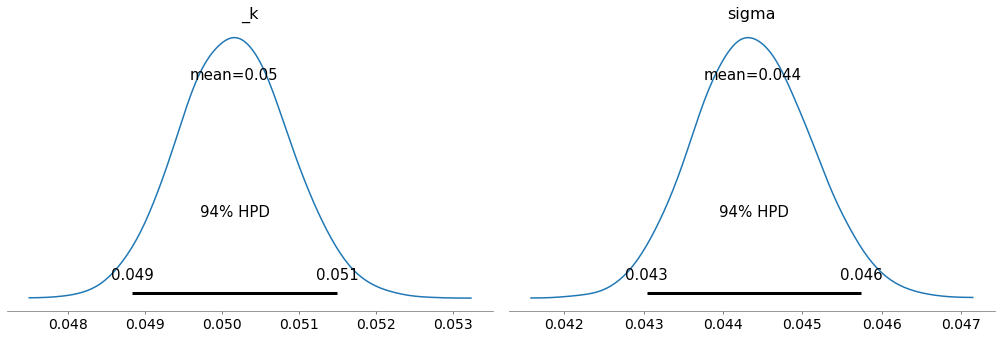

In [140]:
# pm.traceplot(trace[:])
az.plot_posterior(data)

In [126]:
from scipy.linalg import lstsq

trace["_k"].shape
k_samples = trace["_k"]

# k_samples.std()
Cs = np.exp(-k_samples * times[:, None])

STs = np.zeros((k_samples.shape[0], wls.shape[0]))

for i in range(k_samples.shape[0]):
    STs[i] = lstsq(Cs[:, i][:, None], D)[0]

# Cs[:, i].shape, D.shape

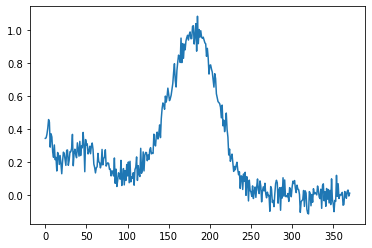

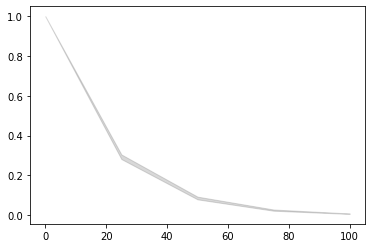

In [131]:
ST_avrg = STs.mean(axis=0)
Cs_avrg = Cs.mean(axis=1)

q_1, q_32, q_68, q_99 = np.quantile(STs, [0.01, 0.32, 0.68, 0.99], axis=0)
q_1, q_32, q_68, q_99 = np.quantile(Cs, [0.01, 0.32, 0.68, 0.99], axis=1)


plt.plot(wls,  ST_avrg)
# plt.fill_between(wls, q_1, q_99, color=(0.5, 0.5, 0.5, 0.3))

plt.show()

# plt.plot(times, Cs_avrg.squeeze())
plt.fill_between(times, q_1, q_99, color=(0.5, 0.5, 0.5, 0.3))

plt.show()


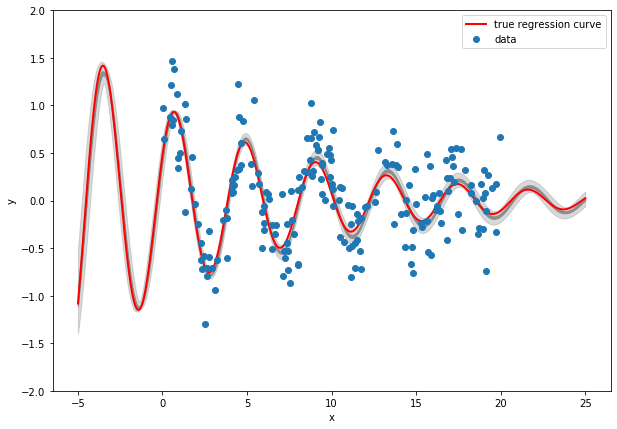

In [7]:
plt.figure(figsize=(10, 7))



# slope_samples = trace[100:]['slope']
# int_samples = trace[100:]['intercept']


# a0_samples = trace[100:]['a0']
# a1_samples = trace[100:]['a1']
# a2_samples = trace[100:]['a2']
# #a3_samples = trace[100:]['a3']


_x = np.linspace(-5, 25, 500)

# curves = a0_samples[:, None] + a1_samples[:, None] * _x[None, :] + a2_samples[:, None] * _x[None, :] ** 2#  + a3_samples[:, None] * _x[None, :] ** 3

curves = _model([a0_samples[:, None], a1_samples[:, None], a2_samples[:, None]], _x[None, :])


# lines = slope_samples[:, None] * _x[None, :] + int_samples[:, None]

# plt.plot(x, lines[::100].T, lw=0.1, color='gray')

true_y = _model(theta, _x)
plt.plot(_x, true_y, label='true regression curve', lw=2., c='r')

q_1, q_32, q_68, q_99 = np.quantile(curves, [0.01, 0.32, 0.68, 0.99], axis=0)


# slope_avrg = slope_samples.mean()
# int_avrg = int_samples.mean()
# line_avrg = slope_avrg  * _x + int_avrg

plt.fill_between(_x, q_32, q_68, color=(0.5, 0.5, 0.5, 0.8))
plt.fill_between(_x, q_1, q_99, color=(0.5, 0.5, 0.5, 0.3))

# plt.fill_between(_x, true_y + 2 * stds, true_y - 2 * stds, color=(0.5, 0.5, 0.5, 0.5))
# plt.fill_between(_x, true_y + 3 * stds, true_y - 3 * stds, color=(0.5, 0.5, 0.5, 0.3))

# plt.plot(_x, _model([a0_samples.mean(), a1_samples.mean(), a2_samples.mean()], _x), label='fit', lw=2., c='b')

plt.plot(x, y, 'o', label='data')



# plt.title('Posterior predictive regression lines')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-2, 2)


plt.show()


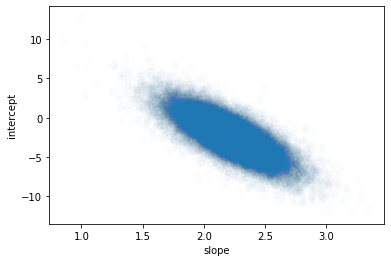

In [9]:
plt.plot(slope_samples[::1], int_samples[::1], 'o', alpha=0.01)
plt.xlabel('slope')
plt.ylabel('intercept')
plt.show()

In [86]:
samples = poisson_param.random(size=500000)

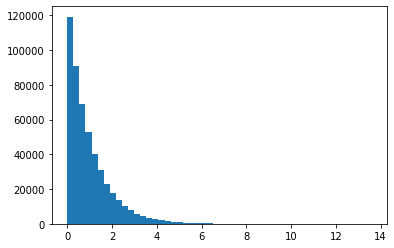

In [90]:
res = plt.hist(samples, bins=50, histtype="stepfilled")

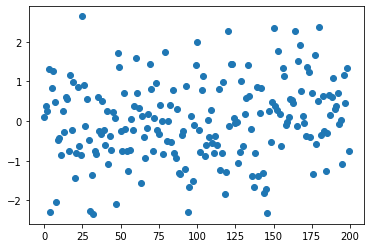

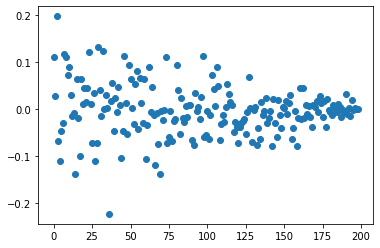

In [37]:
x = np.random.normal(0, 1, size=200)

corr =np.correlate(x, x, mode='full')
corr /= corr.max()
corr = corr[corr.size // 2 + 1:]

plt.plot(x, 'o')
plt.show()
plt.plot(corr, 'o')